# Question 1

In [1]:
library(reshape2)
library(ggplot2)
library(corrplot)

ERROR: Error in library(corrplot): there is no package called 'corrplot'


In [2]:
train.data = read.csv("Task1A_train.csv")
test.data = read.csv("Task1A_test.csv")
train.label = train.data[2]
train.data = train.data[1]
test.label = test.data[2]
test.data = test.data[1]

In [3]:
# KNN function (distance should be one of euclidean, maximum, manhattan, canberra, binary or minkowski)
knn <- function(train.data, train.label, test.data, K=3, distance = 'euclidean'){
    ## count number of train samples
    train.len <- nrow(train.data)
    #print(train.len)
    ## count number of test samples
    test.len <- nrow(test.data)
    
    ## calculate distances between samples
    dist <- as.matrix(dist(rbind(test.data, train.data), method= distance))[1:test.len, (test.len+1):(test.len+train.len)]
    result = {}
    ## for each test sample...
    for (i in 1:test.len){
        ### ...find its K nearest neighbours from training sampels...
        nn <- as.data.frame(sort(dist[i,], index.return = TRUE))[1:K,2]
        ###... and calculate the predicted labels according to the majority vote
        result[i]<- (mean(train.label[nn,]))
    }
    #print(result)
    
    ## return the class labels as output
    return (result)
}

In [4]:
a=test.data
MSE <- data.frame('K'=1:20, 'train'=rep(0,20), 'test'=rep(0,20))
for (k in 1:20){
    MSE[k,'train'] <- sum((train.label-knn(train.data, train.label, train.data, K=k))**2)/nrow(train.label)
    MSE[k,'test'] <-  sum((test.label-knn(train.data, train.label, test.data, K=k))**2)/nrow(train.label)
}


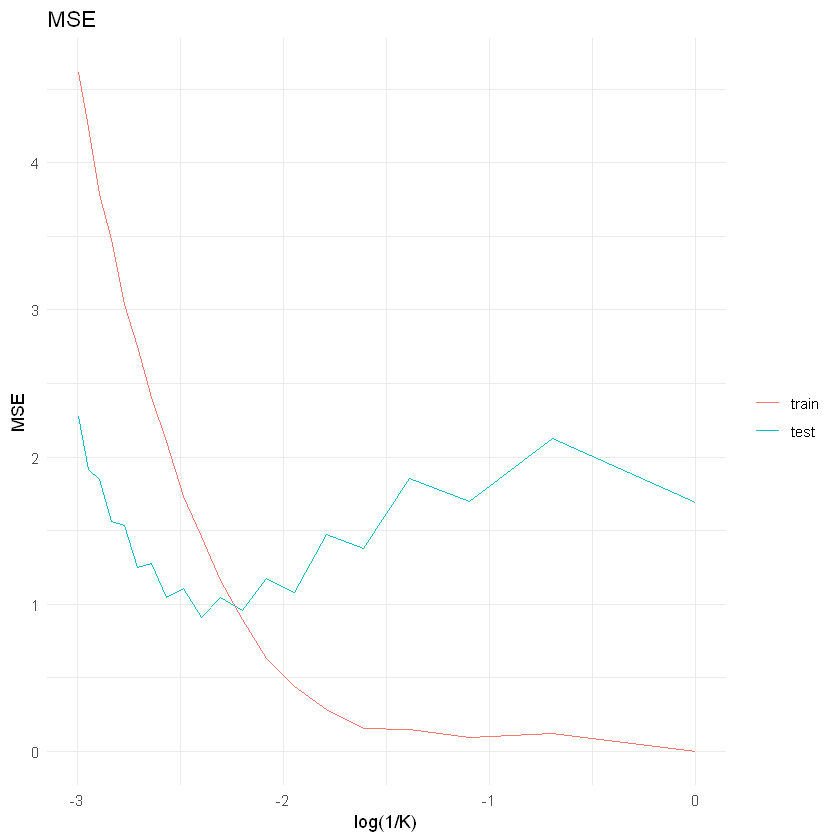

In [5]:
MSE.m <- melt(MSE, id='K') # reshape for visualization
names(MSE.m) <- c('K', 'type', 'MSE')
ggplot(data=MSE.m, aes(x=log(1/K), y=MSE, color=type)) + geom_line() +
       scale_color_discrete(guide = guide_legend(title = NULL)) + theme_minimal() +
       ggtitle("MSE")

Optimum value for K is 11, which minimizes the test error. When K < 11, the model is over-fittting. When K > 11, it is under-fitting. 

## Question 2

In [6]:
train.data = read.csv("Task1A.csv")
train.label = train.data[2]
train.data = train.data[1]

In [7]:
group <- function (original.size, numFold=10){
    sample.size = ceiling(original.size/numFold)
    indx <- matrix(nrow=numFold, ncol=sample.size)
    x = 1:original.size
    for (t in 1:(numFold-1)){
        a= sample(x, size=sample.size, replace = FALSE)
        indx[t, ] = a
        x = setdiff(x,a)
    }
    null = rep(NA,times=sample.size-length(x))
    indx[numFold, ]=c(sample(x,length(x)),null)
    return(indx)
}

In [8]:
# KNN function (distance should be one of euclidean, maximum, manhattan, canberra, binary or minkowski)
knnCV <- function(train.data, train.label, test.data, K=3, distance = 'euclidean'){
    ## count number of train samples
    train.data = as.matrix(train.data)
    train.label = as.matrix(train.label)
    test.data = as.matrix(test.data)
    train.len <- nrow(train.data)
    #print(train.len)
    ## count number of test samples
    test.len <- nrow(test.data)
    
    ## calculate distances between samples
    dist <- as.matrix(dist(rbind(test.data, train.data), method= distance))[1:test.len, (test.len+1):(test.len+train.len)]
    result = {}
    ## for each test sample...
    for (i in 1:test.len){
        ### ...find its K nearest neighbours from training sampels...
        nn <- as.data.frame(sort(dist[i,], index.return = TRUE))[1:K,2]
        ###... and calculate the predicted labels according to the majority vote
        result[i]<- (mean(train.label[nn,]))
    }
    
    ## return the class labels as output
    return (result)
}

In [9]:
cv = function(train.data, train.label, numFold=10, K=3){
    original.size = nrow(train.data)
    cv.indx = group(original.size, numFold)
    MSE = data.frame('D' = 1:numFold, 'train'=rep(0,numFold), 'test'=rep(0,numFold))
    
    for (d in 1:(numFold-1)){
        test.indx = cv.indx[d,]
        train.index = setdiff(1:nrow(train.data),test.indx)
        train.d = train.data[train.index,]
        train.l = train.label[train.index,]
        test.d = train.data[test.indx,]
        test.l = train.label[test.indx,]       
        MSE[d,'train'] = sum((train.l-knnCV(train.d,train.l,train.d, K=K))**2)/length(train.l)
        MSE[d,'test'] = sum((test.l-knnCV(train.d,train.l,test.d, K=K))**2)/length(test.l)
    }
       
    indx.last= cv.indx[numFold,]
    i.last={}
    for (p in indx.last){
        if (!is.na(p)){
            i.last=c(i.last,p)
        }
    }
    test.indx = i.last
    train.index = setdiff(1:nrow(train.data),test.indx)
    train.d = train.data[train.index,]
    train.l = train.label[train.index,]
    test.d = train.data[test.indx,]
    test.l = train.label[test.indx,]
    
    MSE[numFold,'train'] = sum((train.l-knnCV(train.d,train.l,train.d, K=K))**2)/length(train.l)
    MSE[numFold,'test'] = sum((test.l-knnCV(train.d,train.l,test.d, K=K))**2)/length(test.l)
    
    return(MSE)
}

In [10]:
MSE <- data.frame('K'=1:20, 'TrainMSE'=rep(0,20), 'TestMSE'=rep(0,20))
numFold=10
for (k in 1:20){
    result=cv(train.data, train.label, numFold=numFold, K=k)
    MSE[k,'TrainMSE']=sum(result[,2])/numFold
    MSE[k,'TestMSE']=sum(result[,3])/numFold
}
MSE

K,TrainMSE,TestMSE
1,0.0000000,2.0691900
2,0.4963837,1.6622008
3,0.7050007,1.2386137
4,0.7266060,1.2272190
5,0.7634485,1.0830820
6,0.7944057,1.0805710
7,0.7751103,0.9721338
8,0.7268075,1.0754197
9,0.7198172,0.8899209
10,0.7671876,1.0828026


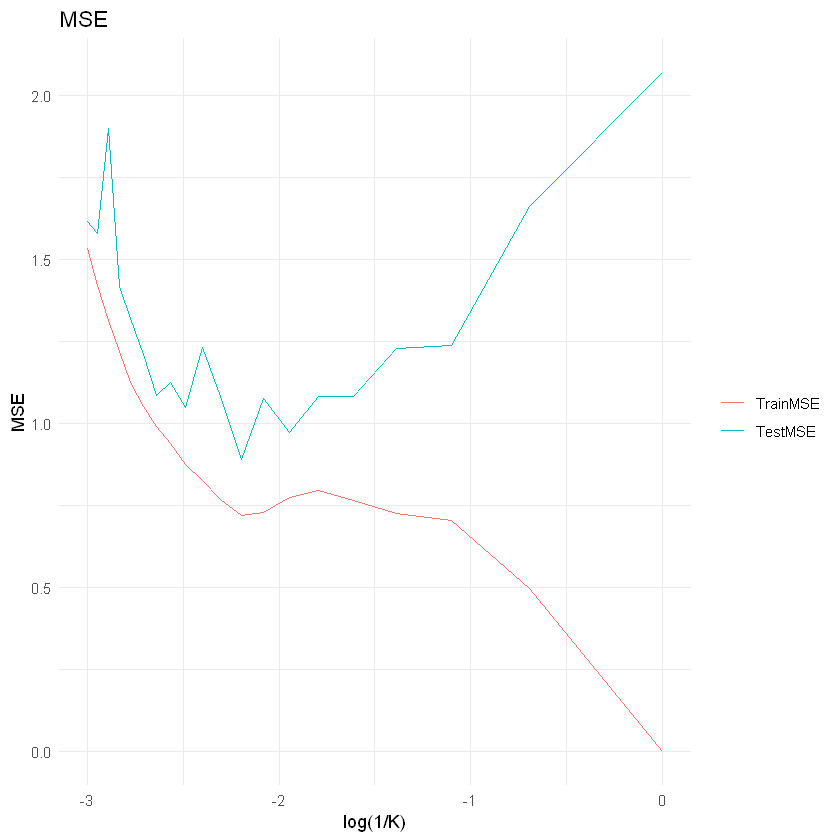

In [11]:
MSE.m <- melt(MSE, id='K') # reshape for visualization
names(MSE.m) <- c('K', 'type', 'MSE')
ggplot(data=MSE.m, aes(x=log(1/K), y=MSE, color=type)) + geom_line() +
       scale_color_discrete(guide = guide_legend(title = NULL)) + theme_minimal() +
       ggtitle("MSE")

## Question 3

In [12]:
train.data = read.csv("Task1B_train.csv")
test.data = read.csv("Task1B_test.csv")
train.label = train.data[5]
train.data = train.data[-5]
test.label = test.data[5]
test.data = test.data[-5]

In [13]:
boot <- function (original.size, sample.size=25, times=100){
    indx <- matrix(nrow=times, ncol=sample.size)
    for (t in 1:times){
        indx[t, ] <- sample(x=original.size, size=sample.size, replace = TRUE)
    }
    return(indx)
}

In [14]:
K <- 20         # Maximum K for KNN 
L <- 100          # number of datasets
N <- 25          # size of datasets
idx = boot(nrow(train.data), N, L)

In [15]:
error = data.frame('K'=1:K, 'L'=1:L, 'test'=rep(0,L*K))
for (k in 1: K){
    ### for every dataset sizes:
    for (l in 1:L){        
        #### calculate iteration index i
        i <- (k-1)*L+l
        indx <- idx[l,]
        #print(indx)
        train.d = train.data[indx,]
        train.l = train.label[indx,]
        error[i,'K'] <- k
        error[i,'L'] <- l
        #print(length(knnCV(train.d, train.l, test.data, k)))
        #### calculate and record the train and test missclassification rates
        error[i,'test'] <-  sum((test.label-knnCV(train.d, train.l, test.data, k))**2)/nrow(test.label)

    }
}

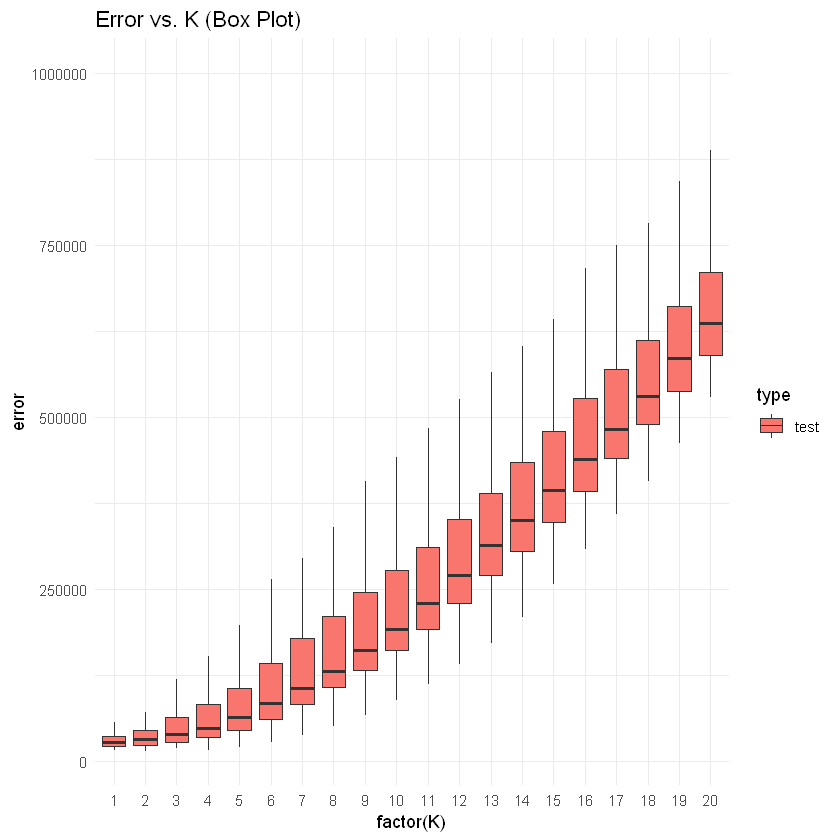

In [16]:
error.m <- melt(error, id=c('K', 'L')) # reshape for visualization
names(error.m) <- c('K', 'L', 'type', 'error')
#error.m
ggplot(data=error.m[error.m$type=='test',], aes(factor(K), error,fill=type)) + geom_boxplot(outlier.shape = NA)  + 
    scale_color_discrete(guide = guide_legend(title = NULL)) + 
    ggtitle('Error vs. K (Box Plot)') + theme_minimal()
# ignore the warnings (because of ignoring outliers)
#options(warn=-1)

In [17]:
error = data.frame('TIMES', 'L', 'test')

k = 10
i = 0
for (n in 1:20){
    
    L = 10 * n
    idx = boot(nrow(train.data), 25, L)

    for (l in 1:L){        
        #### calculate iteration index i
        i <- i+1
        indx <- idx[l,]
        #print(indx)
        train.d = train.data[indx,]
        train.l = train.label[indx,]
        error[i,'TIMES'] <- L
        error[i,'L'] <- l
        #print(length(knnCV(train.d, train.l, test.data, k)))
        #### calculate and record the train and test missclassification rates
        error[i,'test'] <-  sum((test.label-knnCV(train.d, train.l, test.data, k))**2)/nrow(test.label)
    }
}

backup=error


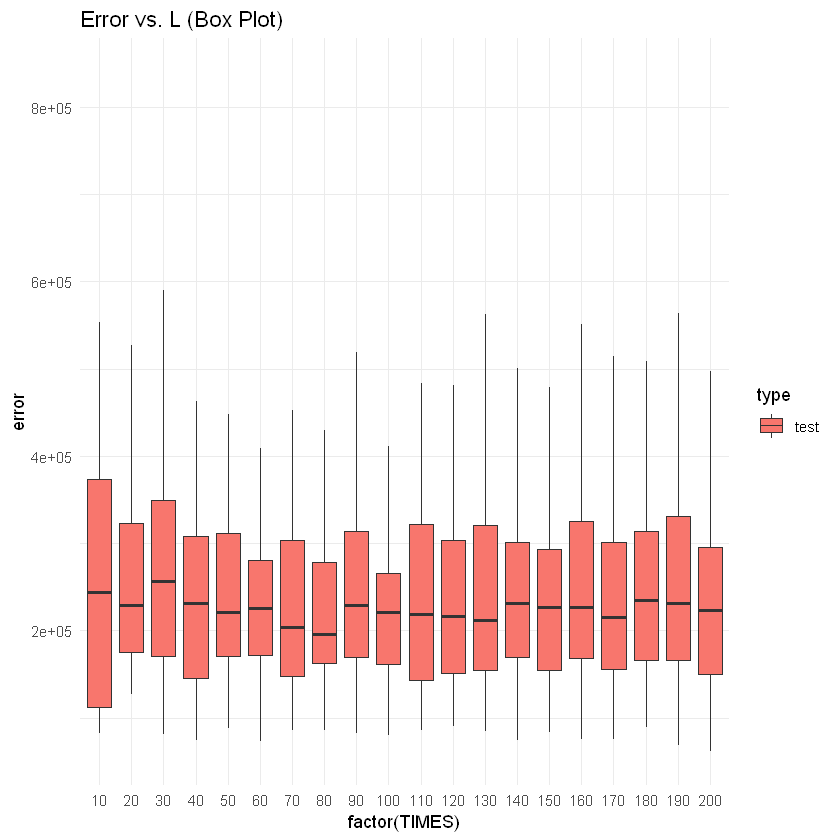

In [25]:
error = backup
error.m <- melt(error[,4:6][,-2], id=c('TIMES')) 
#error.m
names(error.m) <- c('TIMES', 'type', 'error')

ggplot(data=error.m[error.m$type=='test',], aes(factor(TIMES), error,fill=type)) + geom_boxplot(outlier.shape = NA)  + 
    scale_color_discrete(guide = guide_legend(title = NULL)) + 
    ggtitle('Error vs. L (Box Plot)') + theme_minimal()

## Question 4

$P(Blue|Apple)=\frac{P(Apple|Blue)*P(Blue)}{P(Apple)}=\frac{P(Apple|Blue)*P(Blue)}{P(Apple|Blue)*P(Blue)+P(Apple|Red)*P(Red)}=\frac{0.75*0.6}{0.75*0.6+0.25*0.4}=0.8182$

## Question 5

For the i-th dice toss, the probablity of number $n$ is $p(n)=w_n$

and $w_1 +w_2 +w_3 +w_4 +w_5 +w_6 =1$

Likelihood function: $L(w|D)=p(D|w)=w_1^2*w_2*w_3*w_4*w_5^2*w_6^3$

$ln(p(Dlw) = 2ln(w_1)+ln(w_2)+ln(w_3)+ln(w_4)+2ln(w_5)+3ln(w_6)$

Then we find $w$ to maximize the $ln(p(Dlw)$

$w_1=0.2$

$w_2=0.1$

$w_3=0.1$

$w_4=0.1$

$w_5=0.2$

$w_6=0.3$




## Question 6

In [29]:
train = read.csv("Task2A_train.csv")
test = read.csv("Task2A_test.csv")

train.len = nrow(train)
train.index = 1:train.len
train.label = train[train.index,'y']
train.data = train[train.index,1:4]
test.label = test['y']
test.data = test[1:4]

In [30]:
# auxiliary function to calculate labels based on the estimated coefficients
predict_func <- function(Phi, w){
    return(Phi%*%w)
} 

# auxiliary function to calculate a cost function
error_func <- function (Phi, w, label){
    return(sum((predict_func(Phi, w) - label)^2)/2)
}

In [31]:
# project data using a basis function (identical here)
Phi <- as.matrix(cbind('X0'=1, train.data)) # add a column of 1 as phi_0

T <- train.label # rename just for conviniance

tau.max <- 20 # maximum number of iterations
eta <- 0.01 # learning rate
epsilon <- 0.1 * mean(T) # a threshold on the cost (to terminate the process)

W <- matrix(,nrow=tau.max, ncol=ncol(Phi)) # be used to store the estimated oefficients
W[1,] <- runif(ncol(Phi)) # initial weight (any better idea?)

error <- data.frame('tau'=1:tau.max)  # to be used to trace the test and training errors in each iteration

tau <- 1 # iteration counter
terminate <- FALSE

In [32]:
error_func(Phi, W[tau,],T)

[1] 470602008

In [33]:
while(!terminate){
    # check termination criteria:
    terminate <- tau >= tau.max | error_func(Phi, W[tau,],T)<=epsilon
    
    # shuffle data:
    train.index <- sample(1:train.len, train.len, replace = FALSE)
    Phi <- Phi[train.index,]
    T <- T[train.index]
    
    # for each datapoint:
    for (i in 1:train.len){
        print(error_func(Phi, W[tau,],T))
        # check termination criteria:
        if (tau >= tau.max | error_func(Phi, W[tau,],T)<=epsilon) {terminate<-TRUE;break}
        
        t_pred = predict_func(Phi[i,], W[tau,])
        # for each coefficient:
        for (j in 1: ncol(W)){
            # update the coefficient:
            W[(tau+1),j] <- W[tau,j] + eta * (T[i]-t_pred) * Phi[i,j]
        }
        
        # record the error:
        error[tau, 'train'] <- error_func(as.matrix(cbind(1, train.data)), W[tau,],train.label)
        error[tau, 'test'] <- error_func(as.matrix(cbind(1, test.data)), W[tau,],test.label)
        
        # update the counter:
        tau <- tau + 1 
        
    }
}
error.m <- melt(error[1:tau,], id='tau')

# the  final result is:
w <- W[tau,]
w

[1] 470602008
[1] 1.618093e+20
[1] 3.710133e+30
[1] 1.279001e+41
[1] 2.498572e+51
[1] 4.23391e+61
[1] 2.360869e+72
[1] 1.840308e+83
[1] 9.334926e+93
[1] 3.803906e+104
[1] 6.252194e+114
[1] 1.418297e+125
[1] 7.651618e+135
[1] 1.446318e+146
[1] 3.011079e+156
[1] 7.767216e+166
[1] 2.153159e+178
[1] 1.162524e+190
[1] 6.803169e+200
[1] 1.73715e+212


[1]  -1.560026e+97 -3.115989e+100 -5.568142e+100 -8.045841e+100 -4.343583e+100

In [34]:
W

1.307476e-01,5.494227e-01,7.106089e-01,2.581493e-01,3.114445e-01
-1.310454e+01,-2.644331e+04,-5.492985e+04,-8.063841e+04,-3.854351e+04
4.117909e+06,8.209099e+09,6.989665e+09,9.754453e+09,7.993672e+09
-7.098860e+11,-1.416258e+15,-1.465306e+15,-1.845846e+15,-1.316128e+15
1.149733e+17,2.290654e+20,1.986840e+20,2.161609e+20,2.335225e+20
-1.590400e+22,-3.167520e+25,-2.627499e+25,-2.745347e+25,-2.947645e+25
2.683511e+27,5.356216e+30,6.128720e+30,8.828240e+30,4.989453e+30
-6.862102e+32,-1.370122e+36,-1.754126e+36,-2.514550e+36,-1.362951e+36
1.717604e+38,3.425027e+41,3.619486e+41,5.223744e+41,3.906692e+41
-3.687362e+43,-7.354201e+46,-7.960572e+46,-1.006059e+47,-7.528482e+46
6.005778e+48,1.196418e+52,1.011209e+52,1.072088e+52,1.120437e+52


ERROR while rich displaying an object: Error in if ((w[1] * sm + w[2] * cm + w[3] * dm + w[4]) < best$score) break: missing value where TRUE/FALSE needed

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. rep

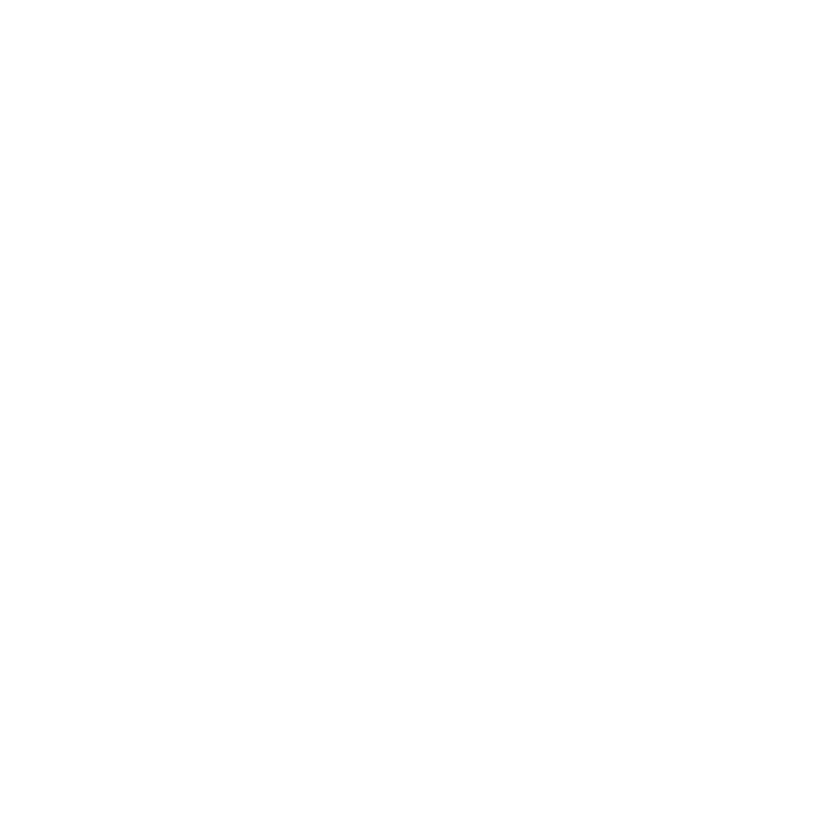

In [35]:
ggplot(data=error.m, aes(x=tau, y=value, color=variable)) +
    geom_line() + ggtitle('Test and Train Error') +
    scale_color_discrete(guide = guide_legend(title = 'Errors')) +theme_minimal()
  